In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
import matplotlib.image as mpimg
from scipy.integrate import cumulative_trapezoid, trapezoid
import math
import time
import random
import os
import pickle as pkl
import geopandas as gpd
from pyproj import *
from shapely.geometry import *
from cratersfd import *
%matplotlib inline

plt.rcParams['font.family'] = 'Helvetica'

In [2]:
ks10_data = pd.read_excel('../data/Sat_satel-summary.xlsx', sheet_name=None)

dione_area = pd.read_excel(
    '../data/dione.xlsx', sheet_name='cp'
)['Area km^2'][0]
dione_data = pd.read_excel(
    '../data/dione.xlsx', sheet_name='cp', skiprows=2
)
dione_ds = np.array(dione_data['Diameter'].tolist())
dione_ds = dione_ds[~np.isnan(dione_ds)]

lunar_crs = '+proj=longlat +a=1738100 +b=1736000 +no_defs'

crater_df = pd.read_csv('../data/lunar_crater_database_robbins_2018.csv')
farside_area = 3.793e7

lon = crater_df['LON_CIRC_IMG']
farside_df = crater_df[(lon > 90) & (lon <= 270)]

a = np.array(farside_df['DIAM_ELLI_MAJOR_IMG'])
b = np.array(farside_df['DIAM_ELLI_MINOR_IMG'])
c_d = np.array(farside_df['DIAM_CIRC_IMG'])
c_ds = c_d[c_d >= 2]
d = np.sqrt(a * b)
farside_ds = d[d >= 2]

basin_sheet = pd.read_csv('../data/basin-synthesis.csv')
basin_areas = basin_sheet.columns.tolist()[1:]
basin_keys = basin_sheet.iloc[0].tolist()[1:]
basin_area_dict = {
    moon : float(area_str) 
    for moon, area_str 
    in zip(basin_keys, basin_areas)
}
basin_df = pd.read_csv(
    '../data/basin-synthesis.csv', skiprows=1
)
basin_dict = dict(basin_df)
basin_ds_dict = {
    moon : np.array(basin_dict[moon][~basin_dict[moon].isna()])
    for moon in basin_keys
}

/Users/sam/Library/Python/3.12/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/sam/Library/Python/3.12/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/sam/Library/Python/3.12/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/sam/Library/Python/3.12/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/sam/Library/Python/3.12/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/sam/Library/Python/3.12/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and wi

In [3]:
keys = ks10_data.keys()
d_dict = {key : np.array(ks10_data[key]['D (km)']) for key in keys}
area_dict = {key : ks10_data[key]['Area (km^2)'][0] for key in keys}
d_dict['Dione-cp'] = dione_ds
area_dict['Dione-cp'] = dione_area

d_max_dict = {
    'Mimas' : 120, 
    'Enceladus-cp' : 110, 
    'Tethys' : 230, 
    'Dione-cp' : 210, 
    'Rhea' : 550,
    'Iapetus-bright' : 310,
    'Iapetus-dark' : 550
}

In [4]:
n_steps = 1000
fontsize = 9
ylim = [8E-3, 5.5E-1]
xlim = [2, 650]
color_dict = {
    'Mimas' : 'blue', 
    'Enceladus-cp' : 'xkcd:hot pink', 
    'Tethys' : 'red', 
    'Dione-cp' : 'orange', 
    'Rhea' : 'forestgreen',
    'Iapetus-bright' : 'silver', 
    'Iapetus-dark' : 'xkcd:dark gray'
}
growth_rate = 1.25





def saturation_model_figure():
    ax = plt.gca()
    key = 'Dione-cp'
    ds = d_dict[key]
    area = area_dict[key]
    X, mean_Y = plot_sash_R(
        ds, area, 
        bin_width_exponent=per_decade(18), 
        d_max=d_max_dict[key], 
        growth_rate=growth_rate, color=color_dict[key], 
        lw=4, fontsize=fontsize
    )
    
    inflection_D = X[np.argmax(mean_Y)]
    
    equilibrium_pf = linear_pf_R(alpha=2.73, D=100, R=9E-2)
    
    D = np.logspace(
        np.log10(xlim[0]), np.log10(xlim[1]), 10000
    )
    
    plt.plot(D, equilibrium_pf(D), 'blue', lw=1.0)
    
    quasi_equilibrium_pf_1 = linear_pf_R(
        alpha=1.6, D=inflection_D, R=8E-1
    )
    quasi_equilibrium_pf_2 = linear_pf_R(
        alpha=3.0, D=inflection_D, R=8E-1
    )
    quasi_equilibrium_pf_3 = linear_pf_R(
        alpha=1.0, D=130, R=quasi_equilibrium_pf_2(130)
    )
    def quasi_equilibrium_pf(D):
        return np.piecewise(
            D, 
            [
                D < inflection_D, 
                (D >= inflection_D) & (D < 130),
                D >= 130
            ],
            [
                quasi_equilibrium_pf_1(D[D < inflection_D]), 
                quasi_equilibrium_pf_2(D[(D >= inflection_D) & (D < 130)]),
                quasi_equilibrium_pf_3(D[D >= 130])
            ]
        )
    
    plt.plot(D, quasi_equilibrium_pf(D), 'red', lw=1.0)
    
    plt.ylim([3E-2, 9E-1])
    plt.xlim(xlim)
    
    lines = plt.gca().get_lines()
    legend = plt.legend(
        lines, [
            'Observed Dione cratered plains SFD',
            'Equilibrium model production function',
            'Quasi-equilibrium model production function'
        ], fontsize=6, labelspacing=0.2
    )

    ltr = 'b'
    plt.text(
        2.15, 0.82, ltr, ha='left', va='top', size=16
    )

    ax = plt.gca()
    ax.xaxis.labelpad = -2
    ax.yaxis.labelpad = -2
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    ax.tick_params(axis='both', which='major', pad=0)





def sash_rise_over_run_alphas(bins, ds, X, mean_Y):
    alphas = []
    for i in range(bins.shape[0] - 1):
        ei, ei1 = bins[i], bins[i + 1]
        ei1 = min(ei1, np.max(ds) * 3)
        logYi = np.log10(np.interp(ei, X, mean_Y))
        logYi1 = np.log10(np.interp(ei1, X, mean_Y))
        rise = logYi1 - logYi
        run = np.log10(ei1 / ei)
        alphas.append(-1 * rise / run - 1)
    return alphas

def dione_zero_crater_correction_figure():
    ax = plt.gca()
    
    growth_rate = 1.25
    
    key = 'Dione-cp'
    ds = d_dict[key]
    area = area_dict[key]
    
    sash_X, sash_Y, _ = calc_sash(
        ds, area, 
        bin_width_exponent=per_decade(18), 
        d_max=d_max_dict[key], 
        growth_rate=growth_rate
    )
    
    counts, bins, _, _ = bin_craters(
        dione_ds, reference_point=1., bin_width_exponent=0.5,
        min_count=0
    )
    X, dif = dif_line(
        sash_rise_over_run_alphas(bins, ds, sash_X, sash_Y), 
        counts, dione_area, bins, return_X=True
    )
    R = dif * X**3
    
    plt.plot(X, R, 'orange', lw=0.7)
    plt.xscale('log')
    plt.yscale('log')
    extended_bins = np.array(
        list(bins[:-2]) + [d_max_dict[key]]
    )
    
    counts, _ = np.histogram(dione_ds, extended_bins)
    
    X_extended, dif = dif_line(
        sash_rise_over_run_alphas(extended_bins, ds, sash_X, sash_Y), 
        counts, dione_area, extended_bins, return_X=True
    )
    R_extended = dif * X_extended**3
    
    plt.plot(
        X_extended[X_extended > bins[-3]], 
        R_extended[X_extended > bins[-3]], 
        'orange', lw=2
    )
    last_bin_d = np.sqrt(bins[-2] * bins[-1])
    corrected_R = np.interp(last_bin_d, X_extended, R_extended)
    lambda_rv = lambda_pdf(counts[-1])
    corrected_R_rv = corrected_R * lambda_rv / lambda_rv.mode()
    plot_pdf_list(
        [last_bin_d], [corrected_R_rv], color='orange', 
        ms=8, elinewidth=5, fontsize=fontsize, alpha=0.5
    )
    
    final_alpha = sash_rise_over_run_alphas(
        bins, ds, sash_X, sash_Y
    )[-1]
    
    counts, basin_bins, _, _ = bin_craters(
        basin_ds_dict['Dione'], 
        bin_width_exponent=0.5, reference_point=2**(0.5 * 13),
        start_at_reference_point=True, min_count=0
    )
    basin_bins[0] = 100
    
    X, dif = dif_line(
        np.array([final_alpha] * basin_bins.size), 
        counts, basin_area_dict['Dione'], basin_bins, return_X=True
    )
    R = dif * X**3
    plt.plot(X, R, 'blue', lw=0.7)
    
    extended_bins = np.array(
        list(basin_bins[:-2]) + [800]
    )
    
    counts, _ = np.histogram(basin_ds_dict['Dione'], extended_bins)
    
    X_basin_extended, dif = dif_line(
        np.array([final_alpha] * extended_bins.size), 
        counts, basin_area_dict['Dione'], 
        extended_bins, return_X=True
    )
    R_basin_extended = dif * X_basin_extended**3
    plt.plot(
        X_basin_extended[X_basin_extended > basin_bins[-3]], 
        R_basin_extended[X_basin_extended > basin_bins[-3]], 
        'blue', lw=2
    )
    last_basin_bin_d = np.sqrt(basin_bins[-2] * basin_bins[-1])
    corrected_basin_R = np.interp(
        last_basin_bin_d, X_basin_extended, R_basin_extended
    )
    lambda_rv = lambda_pdf(counts[-1])
    corrected_basin_R_rv = corrected_basin_R * lambda_rv / lambda_rv.mode()
    plot_pdf_list(
        [last_basin_bin_d], [corrected_basin_R_rv], color='blue', 
        ms=6, elinewidth=3, alpha=0.5, marker='o', fontsize=fontsize
    )
    
    plot_R(
        basin_ds_dict['Dione'], basin_area_dict['Dione'],
        bins=basin_bins, marker='o', min_count=0,
        color='blue', elinewidth=2, ms=3
    )
    plot_R(
        dione_ds, dione_area, reference_point=1, ms=3,
        bin_width_exponent=0.5, do_correction=False,
        color='orange', elinewidth=0.5, fontsize=fontsize
    )
    plt.xlim(xlim)
    plt.ylim([2E-2, 3.5E-1])
    
    lines = plt.gca().get_lines()
    lines = [lines[i] for i in [0, 1, 7, 2, 3, 4, 6, 5]]
    line_labels = [
        'R line of Dione cratered plains',
        'Extended final bin of R line',
        'Binned R plot',
        'Corrected final bin',
        'R line of Dione basins',
        'Extended final bin of basin R line',
        'Binned basin R plot',
        'Corrected final basin bin'
    ]
    plt.legend(
        lines, line_labels, fontsize=6, loc='lower left',
        labelspacing=0.2
    )
    ltr = 'c'
    plt.text(
        2.15, 3.3E-1, ltr, ha='left', va='top', size=16
    )

    ax = plt.gca()
    ax.xaxis.labelpad = -2
    ax.yaxis.labelpad = -2
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    ax.tick_params(axis='both', which='major', pad=0)




def main_results_fig():
    ax = plt.gca()
    plot_keys = [
        'Mimas', 'Enceladus-cp', 'Tethys', 'Dione-cp', 'Rhea',
        'Iapetus-bright', 'Iapetus-dark'
    ]
    for key in plot_keys:
        ds = d_dict[key]
        area = area_dict[key]
        X, mean_Y = plot_sash_R(
            ds, area, 
            bin_width_exponent=per_decade(18), 
            d_max=d_max_dict[key], 
            growth_rate=growth_rate, color=color_dict[key], 
            lw=1.5, fontsize=fontsize
        )
    lines = plt.gca().get_lines()
    legend = plt.legend(
        lines, plot_keys, fontsize=6, labelspacing=0.2,
        loc='lower left'
    )
    plt.xlim(xlim)
    plt.ylim(ylim)
    frame = legend.get_frame()
    plt.text(
        5.3, 0.5, 
        (
            'Enceladus data from Kirchoff and Schenk (2009)'
            '\nAll other data from Kirchoff and Schenk (2010)'
        ),
        ha='left', va='top', fontsize=6, bbox={
            'boxstyle' : 'round',
            'facecolor' : frame.get_facecolor(),
            'edgecolor' : frame.get_edgecolor(),
            'linewidth' : frame.get_linewidth(),
            'alpha' : frame.get_alpha(),
        }
    )
    ltr = 'a'
    plt.text(
        2.15, 0.53, ltr, ha='left', va='top', size=16
    )
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.xaxis.labelpad = 3
    ax.yaxis.labelpad = -2
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    ax.tick_params(axis='both', which='major', pad=0)





def synthetic_modeling_figure(key):
    ax = plt.gca()
    ds = d_dict[key]
    area = area_dict[key]
    X, mean_Y = plot_sash_R(
        ds, area, 
        bin_width_exponent=per_decade(18), 
        d_max=d_max_dict[key], 
        growth_rate=growth_rate, color=color_dict[key],
        fontsize=fontsize
    )

    if key == 'Iapetus-dark':
        r_pf = fit_pf(X, mean_Y)
        at = X[X > 20][np.argmax(r_pf(X[X > 20]))]
    else:
        at = None
    saturated_pf = get_saturated_pf(
        X, mean_Y, plot_type='R', at=at
    )
    file_stem = 'saved/steep_branch_synth.'
    base = file_stem + key + '.' + str(n_steps)
    X_saved = os.path.exists(base + '.X.csv')
    Ys_saved = os.path.exists(base + '.Ys.csv')
    load_saved = X_saved and Ys_saved
    time0()
    if load_saved:
        X = np.loadtxt(base + '.X.csv', delimiter=',')
        Ys = np.loadtxt(base + '.Ys.csv', delimiter=',')
        X, Ys = plot_sash_synth(
            ds, area, plot_type='R',
            differential_pf=R2differential_pf(saturated_pf), 
            n_steps=n_steps, bin_width_exponent=per_decade(18), 
            d_max=d_max_dict[key], growth_rate=growth_rate, 
            color=color_dict[key], fontsize=fontsize,
            X=X, synth_mean_Ys=Ys
        )
    else:
        X, Ys = plot_sash_synth(
            ds, area, plot_type='R',
            differential_pf=R2differential_pf(saturated_pf), 
            n_steps=n_steps, bin_width_exponent=per_decade(18), 
            d_max=d_max_dict[key], growth_rate=growth_rate, 
            color=color_dict[key], fontsize=fontsize
        )
        np.savetxt(base + '.X.csv', X, delimiter=',')
        np.savetxt(base + '.Ys.csv', Ys, delimiter=',')
    runtime('Synthetic calculation time')

    lines = plt.gca().get_lines()
    legend = plt.legend(
        lines, [
            'Observed ' + key + ' SFD', 
            'Synthetic model\nwithout steep branch'
        ], fontsize=6, loc='lower left', labelspacing=0.2
    )
    for text in legend.get_texts():
        text.set_linespacing(1.05)
    plt.xlim(xlim)
    plt.ylim(ylim)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    if i >= 3:
        ax.set_xticklabels([])
        plt.xlabel('')

    ltr = chr(ord('d') + i)
    plt.text(
        2.2, 0.5, ltr, ha='left', va='top', size=16
    )
    ax.xaxis.labelpad = 3
    ax.yaxis.labelpad = 1
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    ax.tick_params(axis='both', which='major', pad=0)





def iapetus_comparison_figure():
    global i
    ax = plt.gca()
    key = 'Iapetus-bright'
    bright_ds = ks10_data[key]['D (km)']
    bright_area = ks10_data[key]['Area (km^2)'][0]
    D_bright, R_bright = plot_sash_R(
        bright_ds, bright_area, 
        bin_width_exponent=per_decade(18), 
        d_max=d_max_dict[key], 
        growth_rate=growth_rate, color=color_dict[key], lw=1.7
    )
    key = 'Iapetus-dark'
    dark_ds = ks10_data[key]['D (km)']
    dark_area = ks10_data[key]['Area (km^2)'][0]
    D_dark, R_dark = calc_sash_R(
        dark_ds, dark_area, 
        bin_width_exponent=per_decade(18), 
        d_max=d_max_dict[key], 
        growth_rate=growth_rate
    )
    X = np.linspace(7, 8, 10000)
    Y_bright = np.interp(X, D_bright, R_bright)
    Y_dark = np.interp(X, D_dark, R_dark)
    crossover_d = X[np.argmin(np.abs(Y_bright - Y_dark))]
    bright_R_pf = fit_pf(D_bright, R_bright)
    dark_R_pf = fit_pf(D_dark, R_dark)
    def synth_R_pf(d, crossover_d=crossover_d):
        return np.piecewise(
            d, [d < crossover_d, d >= crossover_d],
            [bright_R_pf, dark_R_pf]
        )
    time0()
    base = 'saved/iapetus_synth.' + str(n_steps)
    X_saved = os.path.exists(base + '.X.csv')
    Ys_saved = os.path.exists(base + '.Ys.csv')
    load_saved = X_saved and Ys_saved
    time0()
    if load_saved:
        X = np.loadtxt(base + '.X.csv', delimiter=',')
        Ys = np.loadtxt(base + '.Ys.csv', delimiter=',')
        X, Ys = plot_sash_synth(
            bright_ds, bright_area, plot_type='R',
            differential_pf=R2differential_pf(synth_R_pf), 
            n_steps=n_steps, bin_width_exponent=per_decade(18), 
            d_max=d_max_dict['Iapetus-bright'], 
            growth_rate=growth_rate, fontsize=fontsize, X=X,
            color=color_dict['Iapetus-dark'], synth_mean_Ys=Ys
        )
    else:
        X, Ys = plot_sash_synth(
            bright_ds, bright_area, plot_type='R',
            differential_pf=R2differential_pf(synth_R_pf), 
            n_steps=n_steps, bin_width_exponent=per_decade(18), 
            d_max=d_max_dict['Iapetus-bright'], 
            growth_rate=growth_rate, fontsize=fontsize, 
            color=color_dict['Iapetus-dark']
        )
        np.savetxt(base + '.X.csv', X, delimiter=',')
        np.savetxt(base + '.Ys.csv', Ys, delimiter=',')
    runtime('Synthetic calculation time')
    i += 1
    plt.xlim(xlim)
    plt.ylim(ylim)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    if i >= 3:
        ax.set_xticklabels([])
        plt.xlabel('')
    
    ltr = chr(ord('d') + i)
    plt.text(
        2.2, 0.5, ltr, ha='left', va='top', size=16
    )
    ax.xaxis.labelpad = 3
    ax.yaxis.labelpad = 1
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    ax.tick_params(axis='both', which='major', pad=0)
    lines = plt.gca().get_lines()
    legend = plt.legend(
        lines, [
            'Observed Iapetus-bright SFD', 
            'Synthetic model of the\nIapetus-dark SFD'
        ], fontsize=6, loc='lower left', labelspacing=0.2
    )
    for text in legend.get_texts():
        text.set_linespacing(1.05)





def iapetus_bright_figure():
    global i
    ax = plt.gca()
    key = 'Iapetus-bright'
    bright_ds = ks10_data[key]['D (km)']
    bright_area = ks10_data[key]['Area (km^2)'][0]
    D_bright, R_bright = plot_sash_R(
        bright_ds, bright_area, 
        bin_width_exponent=per_decade(18), 
        d_max=d_max_dict[key], 
        growth_rate=growth_rate, color=color_dict[key], lw=1.7
    )
    tp_mean = truncated_pareto_pdf(
        bright_ds, dmin=safe_d_min(bright_ds),
        dmax=d_max_dict[key]
    ).mean()
    constant_alpha_pf = cumulative2differential_pf(
        linear_pf(slope = -tp_mean)
    )
    time0()
    base = 'saved/iapetus_bright_line_synth.' + str(n_steps)
    X_saved = os.path.exists(base + '.X.csv')
    Ys_saved = os.path.exists(base + '.Ys.csv')
    load_saved = X_saved and Ys_saved
    time0()
    if load_saved:
        X = np.loadtxt(base + '.X.csv', delimiter=',')
        Ys = np.loadtxt(base + '.Ys.csv', delimiter=',')
        X, Ys = plot_sash_synth(
            bright_ds, bright_area, plot_type='R',
            differential_pf=constant_alpha_pf, 
            n_steps=n_steps, bin_width_exponent=per_decade(18), 
            d_max=d_max_dict[key], growth_rate=growth_rate, 
            color=color_dict[key], fontsize=fontsize,
            X=X, synth_mean_Ys=Ys, fill_alpha=0.3
        )
    else:
        X, Ys = plot_sash_synth(
            bright_ds, bright_area, plot_type='R',
            differential_pf=constant_alpha_pf, 
            n_steps=n_steps, bin_width_exponent=per_decade(18), 
            d_max=d_max_dict[key], growth_rate=growth_rate, 
            color=color_dict[key], fontsize=fontsize,
            fill_alpha=0.3
        )
        np.savetxt(base + '.X.csv', X, delimiter=',')
        np.savetxt(base + '.Ys.csv', Ys, delimiter=',')
    runtime('Synthetic calculation time')
    i += 1
    plt.xlim(xlim)
    plt.ylim(ylim)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    if i >= 3:
        ax.set_xticklabels([])
        plt.xlabel('')
    
    ltr = chr(ord('d') + i)
    plt.text(
        2.2, 0.5, ltr, ha='left', va='top', size=16
    )
    ax.xaxis.labelpad = 3
    ax.yaxis.labelpad = 1
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    ax.tick_params(axis='both', which='major', pad=0)
    lines = plt.gca().get_lines()
    legend = plt.legend(
        lines, [
            'Observed Iapetus-bright SFD', 
            'Synthetic model of a\n' + rf'constant $\alpha$ fit'
        ], fontsize=6, loc='lower left', labelspacing=0.2
    )
    for text in legend.get_texts():
        text.set_linespacing(0.9)





def iapetus_dark_figure():
    global i
    ax = plt.gca()
    key = 'Iapetus-dark'
    dark_ds = ks10_data[key]['D (km)']
    dark_area = ks10_data[key]['Area (km^2)'][0]
    D_dark, R_dark = plot_sash_R(
        dark_ds, dark_area, 
        bin_width_exponent=per_decade(18), 
        d_max=d_max_dict[key], 
        growth_rate=growth_rate, color=color_dict[key], lw=1.7
    )
    tp_mean = truncated_pareto_pdf(
        dark_ds, dmin=10,
        dmax=d_max_dict[key]
    ).mean()
    constant_alpha_pf = cumulative2differential_pf(
        linear_pf(slope = -tp_mean)
    )
    time0()
    base = 'saved/iapetus_dark_line_synth.' + str(n_steps)
    X_saved = os.path.exists(base + '.X.csv')
    Ys_saved = os.path.exists(base + '.Ys.csv')
    load_saved = X_saved and Ys_saved
    time0()
    if load_saved:
        X = np.loadtxt(base + '.X.csv', delimiter=',')
        Ys = np.loadtxt(base + '.Ys.csv', delimiter=',')
        X, Ys = plot_sash_synth(
            dark_ds, dark_area, plot_type='R',
            differential_pf=constant_alpha_pf, 
            n_steps=n_steps, bin_width_exponent=per_decade(18), 
            d_max=d_max_dict[key], growth_rate=growth_rate, 
            color=color_dict[key], fontsize=fontsize,
            X=X, synth_mean_Ys=Ys
        )
    else:
        X, Ys = plot_sash_synth(
            dark_ds, dark_area, plot_type='R',
            differential_pf=constant_alpha_pf, 
            n_steps=n_steps, bin_width_exponent=per_decade(18), 
            d_max=d_max_dict[key], growth_rate=growth_rate, 
            color=color_dict[key], fontsize=fontsize
        )
        np.savetxt(base + '.X.csv', X, delimiter=',')
        np.savetxt(base + '.Ys.csv', Ys, delimiter=',')
    runtime('Synthetic calculation time')
    i += 1
    plt.xlim(xlim)
    plt.ylim(ylim)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    if i >= 3:
        ax.set_xticklabels([])
        plt.xlabel('')
    ltr = chr(ord('d') + i)
    plt.text(
        2.2, 0.5, ltr, ha='left', va='top', size=16
    )
    ax.xaxis.labelpad = 3
    ax.yaxis.labelpad = 1
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    # ax.tick_params(axis='both', which='major', pad=0)
    lines = plt.gca().get_lines()
    legend = plt.legend(
        lines, [
            'Observed Iapetus-dark SFD', 
            'Synthetic model of a\n' + rf'constant $\alpha$ fit'
        ], fontsize=6, loc='lower left', labelspacing=0.2
    )
    for text in legend.get_texts():
        text.set_linespacing(0.9)




def iapetus_full_error_figure():
    global i
    ax = plt.gca()
    key = 'Iapetus-bright'
    bright_ds = ks10_data[key]['D (km)']
    bright_area = ks10_data[key]['Area (km^2)'][0]
    key = 'Iapetus-dark'
    dark_ds = ks10_data[key]['D (km)']
    dark_area = ks10_data[key]['Area (km^2)'][0]
    bright_sfd_rv = sash_pdf(
        bright_ds, bright_area, 
        bin_width_exponent=per_decade(18), 
        d_max=d_max_dict['Iapetus-bright'], 
        growth_rate=growth_rate
    )
    dark_sfd_rv = sash_pdf(
        dark_ds, dark_area, 
        bin_width_exponent=per_decade(18), 
        d_max=d_max_dict['Iapetus-dark'], 
        growth_rate=growth_rate
    )
    dmin = 12
    d_random=1.05
    bright_N_rv = N_pmf(
        bright_ds, bright_area, dmin, 
        d_random=d_random, sfd_rv=bright_sfd_rv
    )
    dark_N_rv = N_pmf(
        dark_ds, dark_area, dmin, 
        d_random=d_random, sfd_rv=dark_sfd_rv
    )
    dark_rv = lambda_pdf(
        dark_N_rv, random=1.5, systematic=1.0, additional=1.1,
        apply_error=True, kind='median'
    ) / dark_area
    bright_rv = lambda_pdf(
        bright_N_rv, random=1.5, systematic=1.0, additional=1.1,
        apply_error=True, kind='median'
    ) / bright_area
    xlim = [0.00019, 0.00069]
    key = 'Iapetus-dark'
    dark_rv.plot(
        label=True, xlim=xlim, pdf_label=key, 
        color=color_dict[key], label_color='black',
        label_text_size=8, label_shift_y=0,
        label_shift_x=-5E-6
    )
    key = 'Iapetus-bright'
    bright_rv.plot(
        label=True, upshift=1.2, xlim=xlim, pdf_label=key,
        color=color_dict[key], label_color='black',
        label_text_size=8, label_shift_y=0.7,
        label_shift_x=-5E-6
    )
    plt.xlabel(
        rf'Crater Density (km$^{{-2}}$)', 
        size=fontsize
    )
    i += 1
    ltr = chr(ord('d') + i)
    plt.text(
        0.0002, 2.64, ltr, ha='left', va='top', size=16
    )
    ax.xaxis.labelpad = -1
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    ax.tick_params(axis='x', which='major', pad=0)
    plt.yticks([])
    plt.ylim([-0.2, 2.7])



def lunar_farside_figure():
    global i
    ax = plt.gca()
    XR, R = plot_sash_R(
        farside_ds, farside_area, 
        plot_error=False, bin_width_exponent=per_decade(300),
        growth_rate=growth_rate, d_max=3500, fontsize=fontsize
    )
    Xd = np.logspace(0, 3.5, 10000)
    plt.plot(Xd, 100 * npf_new_R(Xd), 'orange')
    plt.xlim([1.8, 1200])
    plt.ylim([2E-2, 3E-1])
    plt.xscale('log')
    plt.yscale('log')
    lines = plt.gca().get_lines()
    legend = plt.legend(
        lines, [
            (
                'Lunar farside SFD from the'
                '\nRobbins (2019) global database'
            ),
            (
                'Neukum Production Function (NPF)'
                '\n(Neukum, 1983; Ivanov et al., 2001)'
            )
        ], fontsize=6, labelspacing=0.2
    )
    for text in legend.get_texts():
        text.set_linespacing(1.05)
    ax.xaxis.labelpad = -1
    ax.yaxis.labelpad = 1
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    ax.tick_params(axis='both', which='major', pad=0)
    ltr = 'n'
    plt.text(
        1.84, 0.28, ltr, ha='left', va='top', size=16
    )





Calculation time: 1.13743 seconds
Calculation time: 0.93393 seconds
Calculation time: 1.06035 seconds
Calculation time: 0.98123 seconds
Calculation time: 0.00019 seconds
Calculation time: 1.02954 seconds
Calculation time: 0.98647 seconds
Calculation time: 1.14763 seconds
Calculation time: 0.00018 seconds


/Users/sam/Data/chronology/cratersfd/src/cratersfd/random_variable_module.py:184: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([


Synthetic calculation time: 2.20849 seconds
Calculation time: 0.0004 seconds
Synthetic calculation time: 2.21983 seconds
Calculation time: 0.00025 seconds
Synthetic calculation time: 2.23245 seconds
Calculation time: 0.00025 seconds
Synthetic calculation time: 2.24615 seconds
Calculation time: 0.0002 seconds
Synthetic calculation time: 2.20577 seconds
Calculation time: 0.00013 seconds
Synthetic calculation time: 2.21739 seconds
Calculation time: 0.00018 seconds
Synthetic calculation time: 2.23171 seconds
Calculation time: 0.00017 seconds
Synthetic calculation time: 2.24754 seconds
Calculation time: 0.00021 seconds
Synthetic calculation time: 2.25739 seconds
Calculation time: 19.15428 seconds


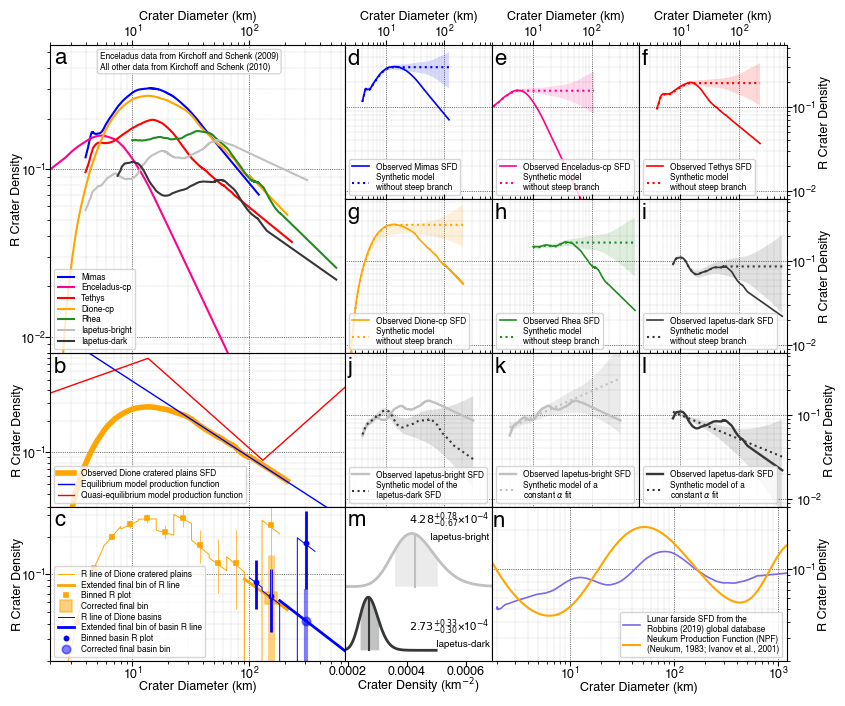

In [5]:
fig = plt.figure(figsize=(9.5, 8))

gs = gridspec.GridSpec(4, 5, figure=fig)

ax = plt.subplot(gs[2, :2])
saturation_model_figure()

ax = plt.subplot(gs[:2, :2])
main_results_fig()

ax = plt.subplot(gs[3, :2])
dione_zero_crater_correction_figure()

plot_keys = [
    'Mimas', 'Enceladus-cp', 'Tethys', 'Dione-cp', 'Rhea',
    'Iapetus-dark'
]
grids = [
    gs[0, 2], gs[0, 3], gs[0, 4], gs[1, 2], gs[1, 3], gs[1, 4]
]

for key, grid, i in zip(
    plot_keys, grids, range(len(grids))
):
    ax = plt.subplot(grid)
    synthetic_modeling_figure(key)

i = len(grids) - 1
ax = plt.subplot(gs[2, 2])
iapetus_comparison_figure()

ax = plt.subplot(gs[2, 3])
iapetus_bright_figure()

ax = plt.subplot(gs[2, 4])
iapetus_dark_figure()

ax = plt.subplot(gs[3, 2])
iapetus_full_error_figure()

ax = plt.subplot(gs[3, 3:])
lunar_farside_figure()

plt.subplots_adjust(wspace=0, hspace=0)
f = 'figs/saturn_cratered_plains_' + str(n_steps) + '.pdf'
plt.gcf().savefig(f, bbox_inches='tight')

In [6]:
print('R plot peaks:')
for key in plot_keys:
    ds = d_dict[key]
    area = area_dict[key]
    X, mean_Y = calc_sash_R(
        ds, area, 
        bin_width_exponent=per_decade(18), 
        d_max=d_max_dict[key], 
        growth_rate=growth_rate
    )
    print(key + ': ' + str(X[np.argmax(mean_Y)]))

R plot peaks:
Mimas: 13.948544958200081
Enceladus-cp: 5.392211472881497
Tethys: 14.788667007589352
Dione-cp: 13.645358354163728
Rhea: 36.37037230439402
Iapetus-dark: 10.067150956743614
